In [1]:
import numpy as np
import matplotlib.pyplot as plt
g=9.81

In [2]:
class X():
    def __init__(self,state=np.zeros(6)):
        self.x,self.y,self.phi=state[0],state[1],state[2]
        self.xDot,self.yDot,self.phiDot=state[3],state[4],state[5]
    def __call__(self):
        return [self.x,self.y,self.phi,self.xDot,self.yDot,self.phiDot]




In [3]:
class Obstacle:
    def __init__(self,x,y,r):
        self.c=np.array([x,y])
        self.r=r
    def CheckCollisionThroughTime(self,state):
        nChecks=state.shape[1]
        for i in range(nChecks):
            currentState=X(state[:,i])
            if self.CheckCollision([currentState.x,currentState.y]):
                return 1
        return 0
    def CheckCollision(self,point,offset=0):
        distance=np.linalg.norm(np.array(point-self.c))
        if distance<=(self.r+offset):
            return 1
    def __call__(self):
        return self.c,self.r
    
class Node():
    def __init__(self,parent=None,pos=None,g=0,h=0):
        self.parent = parent
        self.pos=pos
        self.g,self.h=g,h
        self.f=self.g+self.h
    def __eq__(self,other):
        return self.pos==other.pos
    def __hash__(self):
        return hash(self.pos)
    def __lt__(self,other):
        return self.f<other.f

In [4]:
class PDController:
    def __init__(self,Kp1,Kd1,Kp2,Kd2,Kp3,Kd3,m):
        self.Kp1=Kp1
        self.Kp2=Kp2
        self.Kd1=Kd1
        self.Kd2=Kd2
        self.Kp3=Kp3
        self.Kd3=Kd3
        self.mass=m
        self.phiDesLast=0
    def Controller(self,xDes,yDes,state,dt):
        u1=self.mass*g+self.Kp1*(yDes-state.y)+self.Kd1*(-state.yDot)
        phiDes=self.Kp2*(xDes-state.x)+self.Kd2*(-state.xDot)
        phiDesDot=(phiDes-self.phiDesLast)/dt
        u2=self.Kp3*(phiDes-state.phi)+self.Kd3*(phiDesDot-state.phiDot)
        self.phiDesLast=phiDes
        return [u1,u2]

In [5]:
from scipy.integrate import solve_ivp
goalWidth=20
XLim=800
floor=0
cieling=450


class Quadcopter:
    def __init__(self,m,L,J,state=np.zeros(6)):
        self.M=0    #Moment (ie rotation)
        self.L=L
        self.mass=m
        self.torque=J
        self.F=self.mass*g    #Forward Thrust, EQ point
        self.state=X(state)
        self.diffState=None
        self.Controller=PDController(1,1,1,1,1,1,self.mass)
        self.Trajectory=None
        self.current=None
    def dynamics(self,inputs,state=None):
        if state is not None:
            self.state=X(state)
        self.F,self.M=inputs
        xDDot=-self.F/self.mass*np.sin(self.state.phi)
        yDDot=self.F/self.mass*np.cos(self.state.phi)-g
        phiDDot=self.M/self.torque
        self.diffState=X([self.state.xDot,self.state.yDot,self.state.phiDot,xDDot,yDDot,phiDDot])
        return self.diffState()
    def solve(self,inputs,nSim=[0,15],nChecks=1000):
        nEval = np.linspace(nSim[0],nSim[1],nChecks)
        solution=solve_ivp(fun=lambda t, state: self.dynamics(inputs,state),
                           t_span=nSim,
                           t_eval=nEval,
                           y0=self.state()
                           )
        self.state= X(solution.y[:, -1])
        return solution.y
    
    def trackTrajectory(self,trajectory):
        self.Trajectory=trajectory
        stateHistory=list()
        stateHistory.append(self.state())
        dt=0.1
        t=0
        while self.Trajectory:
            inputs=self.getInputs(dt)
            solution=solve_ivp(
            fun=lambda t, state: self.dynamics(inputs, state),
            t_span=[t, t + dt],
            y0=self.state()
            )
            self.state=X(solution.y[:, -1])
            print(self.state.x, self.state.y)
            stateHistory.append(self.state())
            t+=dt 
        return np.array(stateHistory).T

    def getInputs(self,dt):
        if self.Trajectory==None:
            print("No Path to track")
            return 0 
        if self.current is None:   
            self.current=self.Trajectory.pop(0)
        inputs=self.Controller.Controller(self.current[0],self.current[1],self.state,dt)
        if self.state.x<=self.current[0]+5 and self.state.x>=self.current[0]-5:
            if self.state.y<=self.current[1]+5 and self.state.y>=self.current[1]-5:
                self.current=None
                print("Reached this point :)")
        return inputs
    

In [6]:
import heapq
class AStar:
    def __init__(self,res=1):
        self.gridWidth=int(XLim/res)
        self.gridHeight=int((cieling-floor)/res)
        self.res=res
    def CreateGrid(self,obstacles):
        grid=np.zeros((self.gridHeight,self.gridWidth))
        for r in range(self.gridHeight):
            for c in range(self.gridWidth):
                x,y=self.ConvertToWorld([r,c])
                point=np.array([x,y])

                for obstacle in obstacles:
                    if obstacle.CheckCollision(point,offset=5):
                        grid[r,c]=1
                        break
        self.grid=grid
    
    def ConvertToGrid(self,pos):
        x,y=pos
        c=int(round(x/self.res))
        r=int((round(y-floor)/self.res))
        c=max(0,min(c,self.gridWidth-1))
        r=max(0,min(self.gridHeight-1,r))
        return(r,c)
    
    def ConvertToWorld(self,pos):
        r,c=pos
        x=self.res*c+self.res/2
        y=floor+self.res*r+self.res/2
        return (x,y)
    
    def ReconstructPath(self,endNode):
        path=[]
        node=endNode
        while node is not None:
            path.append(node.pos)
            node=node.parent
        path=path[::-1]
        pathWorld=[self.ConvertToWorld(pos) for pos in path]
        return pathWorld
    def Heuristic(self,start,goal):
        (r1, c1) = start
        (r2, c2) = goal
        return np.sqrt((r1 - r2)**2 + (c1 - c2)**2)
    def Valid(self,pos):
        r,c=pos
        if 0 <= r < self.gridHeight and 0 <= c < self.gridWidth:
            return self.grid[r, c] == 0
        return 0
    
    def PathFind(self,start,end):
        end=self.ConvertToGrid(end)
        start=self.ConvertToGrid(start)

        startNode=Node(None,start,h=self.Heuristic(start,end))
        goalNode=Node(None,end)
        open=list()
        heapq.heappush(open, (startNode.f, startNode))
        gs = {start: 0}

        
        while open:
            _,cNode=heapq.heappop(open)
            if cNode.g>gs.get(cNode.pos,float('inf')):
                continue
            if cNode == goalNode:
                return self.ReconstructPath(cNode)
            
            for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        if dr == 0 and dc == 0:
                            continue 
                        neighbor_pos = (cNode.pos[0] + dr, cNode.pos[1] + dc)
                        if self.Valid(neighbor_pos):
                            move_cost = np.sqrt(2) if dr != 0 and dc != 0 else 1.0 
                            new_g = cNode.g + move_cost

                            if new_g < gs.get(neighbor_pos, float('inf')):
                                gs[neighbor_pos] = new_g
                                new_h = self.Heuristic(neighbor_pos, end)
                                neighbor_node = Node(cNode, neighbor_pos, new_g, new_h)
                                heapq.heappush(open, (neighbor_node.f, neighbor_node))

In [7]:
class SimulationEnviroment:
    def __init__(self,goal=[250,200],res=1):
        self.obstacle=list()
        self.goal=Obstacle(goal[0],goal[1],goalWidth)
        self.pathFinder=AStar(.5)
    def CreateObstacle(self,x,y,r):
        self.obstacle.append(Obstacle(x,y,r))
    def checkSolution(self,solution):
        if (solution[1]<floor).any():
            print("Crashed into the ground")
            #return None
        elif (solution[1]>cieling).any():
            print("Crashed into the cieling")
        for obstacle in self.obstacle:
            if obstacle.CheckCollisionThroughTime(solution):
                print("Crashed into an obstacle")
                #return None
        if self.goal.CheckCollisionThroughTime(solution):
            print("Reached Goal")
        if (solution[0]>XLim).any() or (solution[0]<0).any() :
            print("Crashed into the walls")
    def PlotObjects(self,ax):
        for obstacle in self.obstacle:
            c,r=obstacle()
            circle=plt.Circle((c[0],c[1]),r,color="red",alpha=0.7)
            ax.add_patch(circle)
        c,r=self.goal()   
        circle=plt.Circle((c[0],c[1]),r,color="green",alpha=0.7)
        ax.add_patch(circle)
    def CreatePath(self):
        self.pathFinder.CreateGrid(self.obstacle)
        referencePath=self.pathFinder.PathFind([0,0],self.goal()[0])
        self.Trajectory=referencePath
        return referencePath
            


In [8]:
#Quadcopter and base simulation
m=1; L=1; J=1 #Kg,m,Kgm^2
Quad=Quadcopter(m,L,J)
Env=SimulationEnviroment(goal=[650,400])
Env.CreateObstacle(100,250,100)
Env.CreateObstacle(350,175,50)
Env.CreateObstacle(500,350,50)
Env.CreateObstacle(700,200,75)
Env.CreateObstacle(600,50,115)
sol=Quad.solve([4*m*g,-.2],nChecks=1000) #Inputs, and number of checks
Env.checkSolution(sol)

Crashed into an obstacle
Crashed into an obstacle
Crashed into an obstacle
Crashed into the walls


In [9]:
path=Env.CreatePath()


In [11]:
Quad.trackTrajectory(path)

644559.6171254988 -704089.7979567262
645408.6850925855 -704791.7605404779
646249.0342588556 -705502.7550393642
647080.2550123315 -706206.2881869663
647911.777551225 -706912.0232035391
648731.6331316291 -707613.4321655029
649562.8514964603 -708307.4209308513
650392.2864089096 -708997.8507693611
651228.5415908205 -709700.0126283802
652070.5461949636 -710392.5197576651
652914.8807956818 -711079.5738711399
653752.0243893586 -711756.4059635097
654584.1826953997 -712446.4843178646
655427.7419506395 -713126.489893442
656275.6942088094 -713807.0746619415
657108.4318871637 -714485.0736521106
657937.709917028 -715159.3863851473
658776.8847917047 -715822.7649976849
659623.9081725464 -716479.233118558
660466.7806397148 -717134.2199537228
661300.2535187036 -717784.6141846534
662128.5423890008 -718429.2043984554
662957.5106822912 -719073.1632184236
663783.1636054789 -719715.165057243
664605.6469572084 -720346.952009755
665429.3128902314 -720981.6987261
666256.811760157 -721622.8372712132
667073.6784

KeyboardInterrupt: 

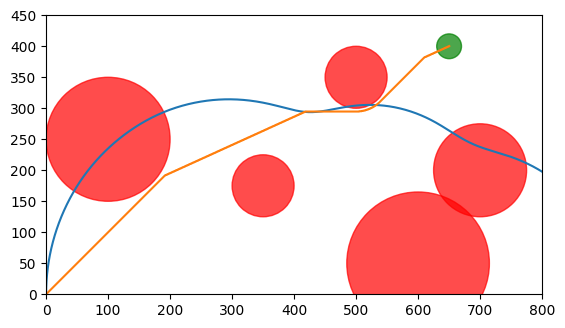

In [ ]:
#Plotting
x,y=sol[0:2]
fig, ax = plt.subplots(1)
ax.plot(x,y)
Env.PlotObjects(ax)
ax.set_aspect('equal',adjustable='box')
ax.set_ylim(floor,cieling)
ax.set_xlim(0,XLim)
path_x = [p[0] for p in path]
path_y = [p[1] for p in path]
ax.plot(path_x,path_y)
plt.show()